#### Version's detail (pour qu'on s'y retrouve)
V2 : Able to parse over wiki page info and turn into csv doc. Strugles with special character and disambiguation pages. Citations counts are weird

V2.1 : Solved the special character problem

V2.2 : Cleaned the table and formated the date. Added a little hist to view page creation along time

V2.3 : Adding a function to pass the 500 treshhold in scraping articles title

V2.4 : Adding the scraping of the titles of sub- and sub-sub-sections

In [1]:
!pip install wikipedia

In [2]:
# This cell has to be run only the first time you use this notebook, as it will install the Python packages you need
# Note that this is NOT the proper way to install a Python package, but this will do the job
import sys
!{sys.executable} -m pip install -U setuptools
!{sys.executable} -m pip install pywikibot
!{sys.executable} -m pip install mwparserfromhell
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install -U nltk
!{sys.executable} -m pip install tqdm

In [3]:
import PIL #library pour afficher des images à partir d'url
import wikipedia
import requests  
import re
from bs4 import BeautifulSoup

In [4]:
# Import libraries
import pywikibot
import pandas as pd
import mwparserfromhell
import numpy as np
from scipy.spatial import distance
from nltk.tokenize import word_tokenize

from tqdm import tqdm
tqdm.pandas()
import time

In [5]:
wikipedia.set_lang("en")  #We make our research in english

In [6]:
def get_section_titles(page : str) -> list[str]:
    section_tit = set()
    section_title = []
    scraped_url = wikipedia.page(page, auto_suggest = False).url
    html_text = requests.get(scraped_url).text
    soup = BeautifulSoup(html_text, 'lxml')
    r = soup.find_all('h2') + soup.find_all('h3') + soup.find_all('h4')
    for i in r:
        if i.find('span', {'class' : 'mw-headline'}) is not None:
            section_tit.add(i.find('span', {'class' : 'mw-headline'})['id'])
    for i in section_tit:
        section_title.append(i.replace('_', ' '))        
    return section_title

In [7]:
def function_to_get_all_the_bloody_titles(key_words):
    titles = []
    a = key_words.lower().replace(' ', '+')
    scraped_url = 'https://en.wikipedia.org/w/index.php?title=Special:Search&limit=5000&offset=0&profile=default&search={}&ns0=1'.format(a)
    html_text = requests.get(scraped_url).text
    soup = BeautifulSoup(html_text, 'lxml')
    r = soup.find('div', {'class' : 'results-info'})
    nbr_result = int(r.get('data-mw-num-results-total'))
    for interest in soup.find_all('div', {'class' : 'mw-search-result-heading'}):
        titles.append(interest.find('a')['title'])
    return titles, nbr_result

In [8]:
#We define a function to automatically set up a corpus of related articles
def corpus_selection(word_keys, key_for_section, number_of_results = 5000):

    corpus = []
    proper_list = []
    left_list = []
    function = function_to_get_all_the_bloody_titles(word_keys)
    nbr_result = function[1]
    search_list = function[0] #Select and put in a list number_of_results wikipedia articles related to word_keys
    
    for article in tqdm(search_list):
        try:
            wikipedia.summary(article, auto_suggest = False)
            proper_list.append(article)
        except wikipedia.exceptions.DisambiguationError as e:
            pass
        except wikipedia.exceptions.PageError as e:
            try:
                wikipedia.summary(article, auto_suggest = False)
                proper_list.append(article)
            except wikipedia.exceptions.PageError as e:
                pass
    
    for proper_article in tqdm(proper_list):
        if key_for_section in proper_article.lower(): #Among these articles, select the ones whose title contains key_for_selection for the corpus
            corpus.append(proper_article)
        else:
            left_list.append(proper_article) #Put the rest of the articles in a list
            
    for left_article in tqdm(left_list):
        sec_tit = []
        try :
            sec_tit = get_section_titles(left_article)
            for section in sec_tit:
                if key_for_section.lower() in section.lower() and left_article not in corpus:
                    corpus.append(left_article)
        except wikipedia.exceptions.DisambiguationError as e:
            pass
        except wikipedia.exceptions.PageError as e:
            try:
                sec_tit = get_section_titles(left_article)
                for section in sec_tit:
                    if key_for_section.lower() in section.lower() and left_article not in corpus:
                        corpus.append(left_article)
            except wikipedia.exceptions.PageError as e:
                pass

    return corpus[:number_of_results]

In [2]:
# Some additional functions
def get_ids_from_ref(ref):
    d = dict(re.findall(r'(doi|pmc|pmid|org)\s?[=\|]\s?([^|\s}]*)', ref))
    ids = {k: v for k, v in d.items() if v}
    return ids
def get_org_from_ref(ref):
    d = dict(re.findall(r'(doi|pmc|pmid|org)\s?[=\|]\s?([^|\s}]*)', ref))
def get_citations(wikicode):
    citations = [c.lower() for c in re.findall(r'<ref(?:\s(?:[^\/]*?))?>(.*?)<\/ref>', wikicode) + re.findall(r'({{(?:cite|vcite2|Cite)\s[^}]*}})', wikicode)]
    s = set()
    for c in citations:
        s.update(c.split('<br/>'))
    ds = pd.DataFrame(s, columns=['ref'])
    ds['ids'] = ds['ref'].apply(get_ids_from_ref)
    ds['pmid'] = ds['ids'].apply(lambda x: x.get('pmid', None))
    ds['doi'] = ds['ids'].apply(lambda x: x.get('doi', None))
    ds['pmc'] = ds['ids'].apply(lambda x: x.get('pmc', None))
    
    ds = ds[(~ds['pmid'].duplicated()) | (ds['pmid'].isnull())]
    ds = ds[(~ds['doi'].duplicated()) | (ds['doi'].isnull())]
    ds = ds[(~ds['pmc'].duplicated()) | (ds['pmc'].isnull())]
    
    dg = pd.DataFrame(s, columns=['ref'])
    dg['ids'] = dg['ref'].apply(get_ids_from_ref)
    dg['org'] = dg['ids'].apply(lambda x: x.get('org', None))
    dg = dg[(~dg['org'].duplicated()) | (dg['org'].isnull())]
    print(dg)
    return {'Ref count': ds.shape[0], 'nb_journal_citations': ds[(~ds['pmid'].isnull()) | (~ds['doi'].isnull()) | (~ds['pmc'].isnull())].shape[0],"citations.org": dg[(~dg['org'].isnull())]}

In [ ]:
%%time
search_list = corpus_selection('Effects of climate change', 'climate change')

  1%|▏         | 63/5000 [00:47<1:01:38,  1.33it/s]C:\Users\ljouv\anaconda3\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\ljouv\anaconda3\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')
 13%|█▎        | 667/5000 [08:22<47:55,  1.51it/s]  

In [ ]:
def protection_status(data):
    
    years_off = []
    for i in range(22):
        years_off.append(2001+i)
    
    wrong_ones = []
    dot = pd.DataFrame(years_off)
    
    for article in data:
        
        html_text = requests.get(('https://en.wikipedia.org/wiki/Special:Log?type=protect&user=&page={}&wpdate=&tagfilter=&subtype=').format(article)).text
        soup = BeautifulSoup(html_text, 'lxml')
        dic = {}
        results = soup.find_all('li', {'class' : 'mw-logline-protect'})
        
        for i in results:
            z = i.find('a')
            protection = i.get('data-mw-logaction')
            date = str(z)[str(z).find('Log">') + 5:str(z).find('</a>')]
            dic[pd.to_datetime(date, format = '%H:%M, %d %B %Y')] = protection
        
        if 'expires' in str(results):
            res = str(results).split('span')
            for string in res:
                if '] (expires' in string:
                    date_get = string[string.find('] (expires ') + 11:string.find(' (UTC))')]
                    if ') [' in date_get:
                        date_get = date_get[:date_get.find(') [')]
                    if '] (' in date_get:
                        date_get = date_get[date_get.find(', '):]
                    if ')' in date_get:
                        date_get = date_get.replace(')', '')
                    if date_get[:2] == ', ':
                        date_get = date_get[2:]
                    if date_get[-1] == ' ':
                        date_get = date_get[:-1]
                    if ',' in date_get:
                        date_get = date_get.replace(',', '')
                    try:
                        dic[pd.to_datetime(date_get, format = '%H:%M %d %B %Y')] = 'protect/unprotect'
                    except:
                        try:
                            dic[pd.to_datetime(date_get, format = '%H:%M %B %d %Y')] = 'protect/unprotect'
                        except:
                            wrong_ones.append(article)

        if len(dic) != 0:
            dic = dict(sorted(dic.items()))
            new_dic = {}
            s = set()
            list_date = list(dic.keys())[::-1]
            for date in list_date:
                s.add(date.year)
            for j in sorted(s):
                deadline = pd.to_datetime('30 June {} 00:00:00'.format(j))
                same_year = []
                for date in list_date:
                    if date.year == deadline.year and date <= deadline:
                        same_year.append(date)
                        if len(same_year) != 0:
                            new_dic[deadline.year] = dic[max(same_year)]
                    else :
                        if date.year == deadline.year and date > pd.to_datetime('30 June {}'.format(max(s))):
                            new_dic[max(s) + 1] = dic[max(list_date)]

            keys = list(new_dic.keys())
            for year in years_off:
                if year < min(keys):
                    new_dic[year] = 'protect/unprotect'
                elif year > max(keys):
                    new_dic[year] = new_dic[max(keys)]
                else:
                    for low in keys:
                        for high in keys:
                            if year > low and year < high and len(keys[keys.index(low):keys.index(high)]) == 1:
                                new_dic[year] = new_dic[low]
                                
            d = dict(sorted(new_dic.items()))
            
            if len(d) == 22:
                dot[article] = d.values()
            else:
                dot[article] = list(d.values())[:22]
        
    return dot

In [ ]:
protection_status_evolution = protection_status(search_list)

In [ ]:
tableau =[] #creation of a list that will contain a dictionnary for each page with the information
for i in range(len(search_list)):
    page =wikipedia.page(search_list[i], auto_suggest = False)
    page_title =page.title #give the clean name of the page
    page_url=page.url #give the url of the page
    site = pywikibot.Site("en", "wikipedia")
    page = pywikibot.Page(site, page_title)
    infopage ={'Name only' : page_title, 'page url' :page_url,'text':page.text}
    tableau.append(infopage)
df=pd.DataFrame.from_dict(tableau)

In [ ]:
print('Getting citations')
df['citations'] = df['text'].progress_apply(lambda x: get_citations(x))
df['Ref count'] = df['citations'].progress_apply(lambda x: x['Ref count'])
df['nb_journal_citations'] = df['citations'].progress_apply(lambda x: x['nb_journal_citations'])
df['citations.org'] = df['citations'].progress_apply(lambda x: x['citations.org'])
for i in df.index:
    df.loc[i,'Sci count']=df.loc[i,'nb_journal_citations']/df.loc[i,'Ref count']
print('Done!')
df.head()

In [ ]:
del df['text']
del df['citations']

In [26]:
df

,Name only,page url,Ref count,nb_journal_citations,Sci count
0,CRISPR,https://en.wikipedia.org/wiki/CRISPR,207,192,0.927536
1,CRISPR gene editing,https://en.wikipedia.org/wiki/CRISPR_gene_editing,186,120,0.645161
2,CRISPR Therapeutics,https://en.wikipedia.org/wiki/CRISPR_Therapeutics,12,1,0.083333
3,Anti-CRISPR,https://en.wikipedia.org/wiki/Anti-CRISPR,31,28,0.903226
4,CRISPR interference,https://en.wikipedia.org/wiki/CRISPR_interference,27,27,1.000000
5,CRISPR activation,https://en.wikipedia.org/wiki/CRISPR_activation,18,16,0.888889
6,The CRISPR Journal,https://en.wikipedia.org/wiki/The_CRISPR_Journal,0,0,NaN
7,CRISPR/Cas Tools,https://en.wikipedia.org/wiki/CRISPR/Cas_Tools,25,23,0.920000
8,CRISPR/Cas12a,https://en.wikipedia.org/wiki/CRISPR/Cas12a,13,6,0.461538
9,Genome-wide CRISPR-Cas9 knockout screens,https://en.wikipedia.org/wiki/Genome-wide_CRIS...,77,74,0.961039


In [ ]:
df.to_csv('10firstScicount.csv')

In [ ]:
titlelist=df["Name only"].tolist() #make a list will all titles
#We need to recreate the wiki url, first step is to get rid of blanks
titleunderscore = [sub.replace(' ', '_') for sub in titlelist]

In [ ]:
#We finally get from the original url to the pageinfo url
urlmodifié = ['https://en.wikipedia.org/w/index.php?title=' + i +'&action=info' for i in titleunderscore]

print(urlmodifié)

In [ ]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
import pandas as pd


In [ ]:
#Cell to scrap infos from "page info" section (2 to scrap the third table of the page)
doblist=[]
creatorlist=[]
totaledits=[]
recentedits=[]
pageid=[]
pagelenght=[]
editprotection=[]
recentpageviews=[]

for i in tqdm(urlmodifié) :
    source = requests.get(i)
    soup = BeautifulSoup(source.text, 'lxml')
    #soup = BeautifulSoup(source, "html.parser", from_encoding="utf-8")
    alltables=soup.findAll('table', {"class": "wikitable mw-page-info"})
    tableau_html_liste=pd.read_html(str(alltables)) #We get it as a list   
    df_pageinfo2=pd.DataFrame(tableau_html_liste[2]) #And make it a df 
    #The number between brackets corresponds to the number of the table according to its order on the html page
    creatorlist += [df_pageinfo2.iat[0, 1]]
    doblist += [df_pageinfo2.iat[1, 1]]
    totaledits += [df_pageinfo2.iat[4, 1]]
    recentedits += [df_pageinfo2.iat[5, 1]]
    
    
    #Scrap of the first table of the page (0)
    df_pageinfo0=pd.DataFrame(tableau_html_liste[0])
    pagelenght += [df_pageinfo0.iat[2, 1]]
    pageid += [df_pageinfo0.iat[3, 1]]
    #recentpageviews += [df_pageinfo0.loc['Page views in the past 30 days']]
            
    
    #Scrap of the second table of the page (1)
    df_pageinfo1=pd.DataFrame(tableau_html_liste[1])
    editprotection += [df_pageinfo1.iat[1, 1]]
  

    

In [ ]:
#df_pageinfo0
#df_pageinfo0.loc['Page ID']

In [ ]:
#Cell to add the new lists as new columns of the df
df["Page id"]=pageid
df["Edit protection"]=editprotection
df["Page lenght (Bytes)"]=pagelenght
df["DOB"]=doblist
df["Creator"]=creatorlist
df["Total edits"]=totaledits
df["Recent edits"]=recentedits
df.head()

In [ ]:
#Cleaning the table

#Getting rid of the time
df["DOB"]= df["DOB"].str.slice(7,100,1) 
#peutêtre qu'on pourrait mettre comme end point la len de la string

#Format the date
df["Formated DOB"]=pd.to_datetime(df["DOB"], format='%d %B %Y')
df["Year_month"]= pd.to_datetime(df['DOB']).dt.to_period('M')

#Getting the year
df['Year'] = pd.DatetimeIndex(df['DOB']).year

#Cleaning the creator 
df["Creator"]= df["Creator"].str.replace(r"\(.*\)",'', regex=True)

### Plot the evolution of the protection status over time

In [ ]:
years_off = []
for i in range(22):
    years_off.append(2001+i)

data_protec = pd.DataFrame(years_off)
for title in protection_status_evolution.columns[1:]:
    l = []
    d = protection_status_evolution.set_index(0)[title]
    for status in d:
        if 'unprotect' in status:
            l.append(0)
        else:
            l.append(1)
    data_protec[title] = l

In [ ]:
data_BOD = pd.DataFrame(years_off).set_index(0)

In [ ]:
zd = pd.DataFrame(data_BOD.sum(axis = 1), columns = ['Total number of articles'])
zd['Number of protected articles'] = data_protec.set_index(0).sum(axis = 1)
zd

In [ ]:
zd.plot.bar(figsize = (10, 5))
plt.xlabel('Years', fontsize = 20)
plt.ylabel('Number of articles', fontsize = 20)
plt.title('a)', loc = 'left',fontsize = 30)

In [ ]:
X = years_off
x_axis = np.arange(len(X))

plt.figure(figsize = (10, 5))
plt.plot(years_off, zd['Number of protected articles']/zd['Total number of articles'])
plt.title('b)', fontsize = 30, loc = 'left')
plt.ylabel('Ratio', fontsize = 20)
plt.xlabel('Years', fontsize = 20)

In [24]:
df.to_csv('Corpus_climate_change_all.csv')

matplotlib.axes._subplots.AxesSubplot

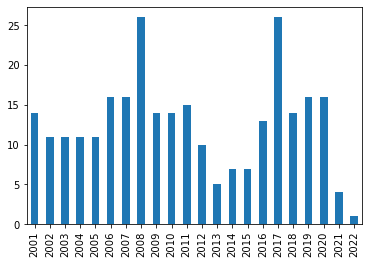

In [ ]:
plothist=df["Year"].value_counts().sort_index().plot(kind="bar")

type(plothist)

#### Next is xtools part, ignore it 

In [ ]:
urlxtools_prose = ["https://xtools.wmflabs.org/api/page/prose/en.wikipedia.org/" + i for i in titleunderscore]
urlxtools_info = ["https://xtools.wmflabs.org/api/page/articleinfo/en.wikipedia.org/" + i for i in titleunderscore]

for i in titleunderscore:
    urlxtools_edits=["https://xtools.wmflabs.org/api/metrics/edits/per-page/en.wikipedia.org/" + i + "/all-editor-types/daily/20010101/20220101"]

In [ ]:
import json
prose_dic=[]
unique_references_xtools=[]
key = "unique_references"
for i in tqdm(urlxtools_prose) :
    prose_str=requests.get(i).text
    prose_dic = json.loads(prose_str)
    
    unique_references_xtools.append(prose_dic[key])


100%|████████████████████████████████████████████████████████████████████████████████| 278/278 [03:13<00:00,  1.44it/s]


In [ ]:
df['unique_references_xtools']=unique_references_xtools

In [ ]:
df.head()
df.to_csv('Corpus_CC_V3.csv')

In [ ]:
for i in urlxtools_edits:
    print(requests.get(i).text)


<!DOCTYPE html>
<html lang="en">
<head>
    <title>
        Error - XTools
    </title>

        <script type="text/javascript">
        xtBaseUrl = "/";

                i18nLang = "en";
        i18nPaths = {};
                    i18nPaths["en"] = "/i18n/en.json";
                    i18nPaths["en"] = "/i18n/en.json";
        
        i18nRTL = false;
    </script>

            <script type="text/javascript" src="https://tools-static.wmflabs.org/cdnjs/ajax/libs/jquery/3.3.1/jquery.min.js"></script>
        <script type="text/javascript" src="/assets/app.753b88d7.js"></script>
        <script type="text/javascript" src="https://tools-static.wmflabs.org/cdnjs/ajax/libs/twitter-bootstrap/3.3.7/js/bootstrap.min.js"></script>
        <script src="https://tools-static.wmflabs.org/cdnjs/ajax/libs/select2/4.0.5/js/select2.full.min.js"></script>
                <link rel="stylesheet" type="text/css" media="screen" href="https://tools-static.wmflabs.org/cdnjs/ajax/libs/twitter-bootstrap/3.3.7